# An Introduction to Neural Networks


* An Introduction to Probabilistic Graphical Models (Skip)
    * Bayesian Networks
    * Hidden Markov Chains
* A review of linear regression
    * linear algebra review
        * row reduction of a matrix 
        * matrix multiplication
        * invertability
    * Implementing linear regression with linear algebra
* Neural Networks
    * Chain Rule over vector spaces
    * psuedo code
    * implementing a basic neural network in raw python
        * Forward propagation
        * Back propagation
    * Issues in convergence
        * vanishing gradient
        * exploding gradient
    * introduction to keras
        * A simple example - regression
        * A simple example - classification
        * neural network architecture design
            * final layer for regression
            * final layer for classification
            * regularization
    * Surogate Models
        * linear regression
        * decision trees
            * feature importance
            * tre interpreter
    * LIME
        * regression example
        * classification example
    * SHAP
        * regression example
        * classification example

# A Review of Linear Regression

In the first part of this tutorial we saw how to implement linear regression using calculus.  In order to build comfort with matrices, which are a central core notion in the design and implementation of neural networks, we will review how to implement linear regression, except this time, using the framing of linear algebra.

The other reason it is helpful to recall our notions around linear regression is neural networks draw from linear regression.  The simplest possible neural network is actually just a set of chained linear regressions.  The power of neural networks is in how one does the chaining of course.  That said, neural nets can be far more complex, interesting, powerful and difficult to understand.  

Finally, it's easy to get lost in all the machinery and choices of neural networks so it's important to ground them in context - neural networks just solve an optimization problem, minimizing error like any other algorithm.  And typically, the way they do that is via Stochastic Gradient Descent.

## A Review of Stochastic Gradient Descent

Recall the following picture:

In [3]:
from IPython.display import HTML
HTML('<img src="NewtonIteration_Ani.gif">')

In it, we can see broadly how gradient descent works - we start with some initial guess, then we use the gradient (which is the same as a derivative) to update that guess and get closer to an optimum.  Optimums are the minimums or maximums of your function, depending on what you are trying to do.  In the case of gradient descent, you are trying to minimize loss, that is the difference between your predicted outcomes and the outcomes you saw in your training data.

## A Review of Linear Algebra

In the previous implementation of Gradient Descent we made use of the derivative directly via calculus to find our optimum, minimizing error.  However, in practice most algorithms make use of the linear algebra formulation of Gradient Descent because linear algebra is extremely power and we have many computational tricks to make it fast.

Before we dive into the implementation, let's review some concepts from linear algebra to get a sense of how to work with matrices and vectors, the mainstays of the subfield.

### Motivating Linear Algebra

One of the general goals of linear algebra is to be able to solve sets of equations simultaneously.  First, let's see how to solve a single equation using simple python:

In [4]:
def equation_one(x):
    return x

def find_zero_eq_one():
    for i in range(-100, 100):
        if equation_one(i) == 0:
            return i
        
print("The 'zero' for equation one is", find_zero_eq_one())

The 'zero' for equation one is 0


Easy enough!  This is the simplest possible way we could "solve" an equation, just guess and check.  Now let's see if this method get's more complex when we make our equation more sophisticated!

In [5]:
def equation_two(x):
    return x + 7

def find_zero_eq_two():
    for i in range(-100, 100):
        if equation_two(i) == 0:
            return i
        
print("The 'zero' for equation two is", find_zero_eq_two())

The 'zero' for equation two is -7


Here we've added a constant, thus changing our equation.  Still pretty simple and we can reuse our solver!  What happens when we go to two variables and add coeficients on our variables?

In [6]:
def arange(start, stop, step):
    iterator = start
    while iterator < stop:
        yield iterator
        iterator += step

def equation_four(x, y):
    return 5*x + 4*y + 7

def find_zero_eq_four(episolon):
    for i in arange(-10, 10, 0.1):
        for j in arange(-10, 10, 0.1):
            if abs(equation_four(i, j)) < episolon:
                return (i, j)
        
print("The 'zero' for equation four is", find_zero_eq_four(0.01))

The 'zero' for equation four is (-9.400000000000002, 9.999999999999963)


Notice, now we need two for loops and also, we can no longer make use of the built-in range function.  Instead, we need access to a far more granular set of numbers - the floating points, instead of the integers.  This also means that we can no longer have equality in our stopping condition:

`if abs(equation_four(i, j)) < episolon`

Now we need set a tolerance for acceptance, a them of many data science algorithms, because typically we work with floating point numbers which (almost) never converge to an integer value.

Let's add yet another variable just to drive the point home:

In [8]:
def arange(start, stop, step):
    iterator = start
    while iterator < stop:
        yield iterator
        iterator += step
        
def equation_four_plus(x, y, z):
    return 5*x + 4*y + 8*z + 7

def find_zero_eq_four_plus(episolon):
    for i in arange(-10, 10, 0.1):
        for j in arange(-10, 10, 0.1):
            for k in arange(-10, 10, 0.1):
                if abs(equation_four_plus(i, j, k)) < episolon:
                    return (i, j, k)
        
print("The 'zero' for equation four plus is", find_zero_eq_four_plus(0.01))

The 'zero' for equation four plus is (-9.8, -9.500000000000002, 9.999999999999963)


Here we see things get even worse!  And now we need 3 for loops!  With every variable we add to a single equation, using classical techniques, like for loops, we will run into trouble fast.  Computationally speaking, linear algebra can make our lives significantly easier, producing algorithms that can solve systems of equations, that is many equations needing to be solved together much faster than the simple for loop scheme we have defined above.

This is the reason no one uses calculus to solve gradient descent, the algorithm simply does not scale the same way.  And with a neural network, you may need to solve thousands or millions of equations simultaneously (typically hundreds).  

Just for completeness, let's look at how to write down how to solve a single equation with an arbitrary number of variables:

In [2]:
from functools import partial
import itertools


def arange(start, stop, step):
    iterator = start
    while iterator < stop:
        yield iterator
        iterator += step

        
def equation_five(coefficients, constant, variables):
    return sum([coefficients[index]*variables[index] 
                for index in range(len(variables))]) + constant


def find_zero_eq_five(coefficients, constant, episolon):
    eq_five = partial(equation_five, coefficients, constant)
    value_range = list(arange(-10, 10, 0.1))
    values = list(itertools.permutations(value_range, len(coefficients)))
    for value in values:        
        if abs(eq_five(value)) < episolon:
                return value

print(find_zero_eq_five([1], 7, 0.1))
print(find_zero_eq_five([1, 2], 7, 0.1))
#print(find_zero_eq_five([1, 2, 3], 7, 0.1))
#print(find_zero_eq_five([1, 2, 3, 4], 7, 0.1))

(-7.000000000000011,)
(-10, 1.4999999999999816)


The reason this solver looks a little more compact is not because it's solving fewer equations, it's because it's getting all the for loops upfront via the permutations function.  This little computational trick makes things a little more tractable computationally speaking, but it doesn't give us enough of a boost to make things tenable.  I could in fact break this notebook just by running the third or fourth example.

## Matrices

We've worked with a few algorithms a lot.  Now we'll introduce a new data structure - the matrix.  A matrix mathematically speaking is a notational convention.  More or less a matrix is just a vector of vectors.  And a vector is just the coefficients of a linear equation.  We've been implicitly using mathematical vectors since we introduced equations above.

## A first example of matrices, Supply and Demand

Let's say that we own and operate a business that sells candy bars.  Assume there is implicit demand for candy bars and many other candy bar sellers.  However, assume our costs are perhaps slightly different from other candy bar sellers, so we can choose what price to sell our candy bar at, subject to our ability to supply candy.  We can also assume we have some supply control because most people aren't patient about candy, they want it when they want it.  So if someone happens by your shop, the price may actually effect their decision to buy the candy or not.

So let's say you have a supply function like:

`price = 2*quantity + 3`

What this equation says is as a business owner, as the price increases you'll want to supply more candy bars, because the perception is, you'll make more money.  

Let's also say there is a demand function like:

`price = 3 - 2*quantity`

This equation says the price you can charge is subject to how many candy bars you make.  So if your shop is filled to the brim and your the only local vendor around, folks will likely be able to always satisfy their craving for candy.  And if you only make a single candy bar, folks will be willing to pay a lot to be the only one to get it.  Because candy is delicious.

Given the above equations we need both the supply and demand equation to find the unique equilibrium of price and quantity such that the market for candy bars is in balance.  This balancing point, all other things held constant, will be the price that maximizes utility for the buyers of candy bars as well as the sellers of candy bars.  And since we are treating our example as idealized, we are in a capitalism regime where the intention is to maximize utility for all.  However, even with the introduction of immorality and therefore businesses or agents acting in subversive ways, all economies are still subject to the above laws generally speaking and therefore understanding this idealized situation still yields value.

So!  Now that we have our supply and demand equations, how do we find the unique price, quantity that yields our equilibrium?  With matrices of course!

First we'll need to turn these equations into the appropriate form:

Supply:

`price - 2*quantity = 3`

Demand:

`price + 2*quantity = 3`

We need to do this so all the variables are on one side of the equation.  Now we can do this:

Supply/Demand Matrix:

$$
  \begin{bmatrix} 1 & -2 \\ 1 & 2 \end{bmatrix} 
  \begin{bmatrix} 3 \\ 3 \end{bmatrix}
$$

Now we have the two resulting mathematical objects, a matrix describing the coeficients of the two equations and a vector describing the solution space.  We'll do something called row reduction on the matrix which will produce unique solutions for the equations.  Before we carry out these operations notice that if our matrix looks like this:

$$
  \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} 
  \begin{bmatrix} a \\ b \end{bmatrix}
$$


Then whatever our variables are, they are equal to a and b respectively.  Because the matrix:

$$
  \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} 
$$

Translates to

$$
  \begin{bmatrix} x \\ y \end{bmatrix}
$$

With the `[a b]` vector this becomes:

$$
x = a \\
y = b
$$

Which solves x and y uniquely!  So now we'll do row reduction to create a matrix which looks like the above one.  And then we'll apply the changes we used on the matrix, onto the solution vector as well.  Which will in turn solve our system of equations!


$\begin{bmatrix} 1 & -2 \\ 1 & 2 \end{bmatrix} $

```
(R[1] = R[1] + R[2])
------------------->
``` 

$ \begin{bmatrix} 2 & 0 \\ 1 & 2 \end{bmatrix} $

```
(R[1] = R[1]/2)
------------------->
``` 

$ \begin{bmatrix} 1 & 0 \\ 1 & 2 \end{bmatrix} $

```
(R[2] = R[2] - R[1])
------------------->
``` 

$ \begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix} $

```
(R[2] = R[2]/2)
------------------->
``` 

$ \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} $

 
Now we'll simply apply the changes to the matrix to the vector:

$ \begin{bmatrix} 3 \\ 3 \end{bmatrix} $

```
(R[1] = R[1] + R[2])
------------------->
``` 

$ \begin{bmatrix} 6 \\ 3 \end{bmatrix} $

```
(R[1] = R[1]/2)
------------------->
```

$ \begin{bmatrix} 3 \\ 3 \end{bmatrix} $

```
(R[2] = R[2] - R[1])
------------------->
```

$ \begin{bmatrix} 3 \\ 0 \end{bmatrix} $

```
(R[2] = R[2]/2)
------------------->
```

$ \begin{bmatrix} 3 \\ 0 \end{bmatrix} $


So the unique solution is:

```
price = 3
quantity = 0
```

What this ends up telling us is it's not possible to optimally operate our candy bar shop.  Which is pretty sad.  So this means we shouldn't open our candy bar shop.  Or we need to change our supply equation by becoming more efficient at producing candy bars.  Of course, it could also be the case that this is truly optimal because candy is bad for you :P.  But that's not really an economic analysis.

In any event, we are now ready to write a program which does row reduction for us, by solving a bunch of very simple equations.  Notice, what we really want is to make the numbers in the matrix that are not on the diagonal zero.  And then we want to make the numbers that are on the diagonal 1.  And then we need to store those operations and apply them to solution matrix.


In [4]:
from functools import partial
from random import random
from sys import setrecursionlimit

def eq_solver(val, func):
    if func(val) > 0:
        val -= 1
        return eq_solver(val, func)
    elif func(val) < 0:
        val += 1
        return eq_solver(val, func)
    else:
        return round(val, 5)
    
    
def eq_float_solver(val, eq, epsilon=0.0001, step_size=0.001, debug=False):
    if abs(eq(val)) < epsilon:
        return round(val, 5)
    elif eq(val) > 0:
        if debug:
            val -= step_size
            return eq_float_solver(val, eq)
        else:
            val -= step_size
            return eq_float_solver(val, eq)
    elif eq(val) < 0:
        if debug:
            val += step_size
            return eq_float_solver(val, eq)
        else:
            val += step_size
            return eq_float_solver(val, eq)
    else:
        return round(val, 5)


def eq_diag_solver(val, eq, epsilon=0.0001, step_size=0.001):
    if abs(eq(val)) - 1 < epsilon:
        return round(val, 5)
    elif eq(val) > 1:
        val -= step_size
        if val == 0:
            val -= step_size
        return eq_float_solver(val, eq)
    elif eq(val) < 1:
        val += step_size
        if val == 0:
            val += step_size
        return eq_float_solver(val, eq)
    else:
        return round(val, 5)
    

def arange(start, stop, step):
    cur = start
    while start < stop:
        yield cur
        cur += step

        
def iterative_solver(eq, start, stop, epsilon=0.0001, step_size=0.001):
    for val in arange(start, stop, step_size):
        if abs(eq(val)) < epsilon:
            return round(val, 5)


def flatten(matrix):
    listing = []
    for row in matrix:
        for elem in row:
            listing.append(elem)
    return listing


def solve_matrix(matrix):
    flattened_matrix = flatten(matrix)
    largest_value = max(flattened_matrix)
    num_zeros = len(str(largest_value))
    val_range = int("1" + "0"*num_zeros)
    steps = []
    cur_matrix = matrix
    for index in range(len(matrix)):
        col_index = index
        row_index = index
        cur_matrix, step = solve_diag(cur_matrix[col_index][row_index],
                                      row_index, col_index, cur_matrix, val_range)
        steps.append(step)
    for row_index in range(len(matrix[0])):
        for col_index in range(len(matrix)):
            if col_index == row_index:
                continue
            print(cur_matrix)
            step = solve_vector(cur_matrix[col_index][row_index], 
                                row_index, col_index, cur_matrix, val_range)
            cur_matrix = linear_combination(cur_matrix, step)
            print(col_index, row_index)
            steps.append(step)
    return steps, cur_matrix


def linear_combination(matrix, step):
    update_row = step[0]
    other_row = step[1]
    transformer = step[2]
    for index in range(len(matrix[0])):
        matrix[update_row][index] = transformer(
            matrix[update_row][index], matrix[other_row][index])
    return matrix
    

def solve_diag(elem, cur_elem_idx, diag_index, matrix, magnitude):
    reciprical = 1/elem
    matrix[diag_index] = [elem*reciprical 
                          for elem in matrix[diag_index]]
    operation = lambda coef, elem: elem*coef
    op = partial(operation, reciprical)
    step = [diag_index, cur_elem_idx, op, None, reciprical, "rescale"]
    return matrix, step


def solve_vector(elem, cur_elem_idx, diag_index, matrix, magnitude):
    for row_index, matrix_row in enumerate(matrix):        
        if matrix_row[cur_elem_idx] != 0 and row_index != diag_index:
            other_elem = matrix_row[cur_elem_idx]
            other_row = row_index
            break
    eq_to_solve = lambda elem, other_elem, coef: elem + coef*other_elem
    to_solve = partial(eq_to_solve, elem, other_elem)
    start, stop = magnitude*-1, magnitude
    coef = iterative_solver(to_solve, start=start, stop=stop)
    operation = lambda coef, elem, other: elem + coef*other
    op = partial(operation, coef)
    return [diag_index, cur_elem_idx, op, other_row, coef, "linear_combo"]


def apply_steps(vector, steps):
    for step in steps:
        if step[-1] == "linear_combo":
            idx = step[0]
            other_idx = step[3]
            coef = step[4]
            vector[idx] = vector[idx] + coef*vector[other_idx]
        else:
            idx = step[0]
            coef = step[4]
            vector[idx] = vector[idx]*coef
    return vector


#setrecursionlimit(10000)
if __name__ == '__main__':
    matrix = [[1, -2], [1, 2]]
    steps, cur_matrix = solve_matrix(matrix)
    print(apply_steps([3, 3], steps))


[[1.0, -2.0], [0.5, 1.0]]
1 0
[[1.0, -2.0], [0.0, 2.0]]
0 1
[3.0, 0.0]


I present the above solution for completeness, in case folks are interested in how to do this from scratch.  

## Matrix Operations (Digression)

Now that we've seen the power of matrices to allow us to solve systems of equations, let's briefly talk about some of their operations:

* Addition
* Multiplication

Matrix Addition is as simple as you'd suspect, simply go across and add each element in the same row column position:

$$
  \begin{bmatrix} 1 & -2 \\ 1 & 2 \end{bmatrix} 
  + 
  \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix}
  =
  \begin{bmatrix} 2 & -1 \\ 2 & 3 \end{bmatrix}
$$

Notice, the matrices are of the same size, and must be!  So that means you can't add two matrices of different shapes!

Next let's look at multiplication:

Matrix Multiplication is far more complicated, you have to go across the ith row and jth column to get the i,j entry.  This is best seen with an example:

$$
  \begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix} 
  * 
  \begin{bmatrix} 2 & 1 \\ 4 & 3 \end{bmatrix}
  =
  \begin{bmatrix} 10 & 7 \\ 22 & 15 \end{bmatrix}
$$

In order to recover the position at index 1, 1 (matrices are indexed starting at 1 in mathematical notation), you'd need to do:

$$ 1*2 + 2*4 = 10 $$

To make it clear what happens you take the first row of the first matrix: 1, 2 and multiply it by the first column of the second matrix: 2, 4 element by element and then sum the two multiplications.

This means that matrix multiplication is not communitive!  Which means:

$$ A*B \neq B* A $$

For matrices A and B.

Additionally, matrix mulitplication need not operate over matrices of the exact same size.  Therefore we can do things like this:

$$
  \begin{bmatrix} 1 & 2 & 3\\ 3 & 4 & 5\end{bmatrix} 
  * 
  \begin{bmatrix} 2 & 1 \\ 4 & 3 \\ 5 & 6 \end{bmatrix}
  =
  \begin{bmatrix} 25 & 25 \\ 47 & 45 \end{bmatrix}
$$

The only requirement is that our matrices be composable, that is, the number of columns of the first matrix is the same as the number of rows as the second matrix.  It's very important to understand how to compose matrices of different shapes because our individual layers of our neural network are in fact matrices.  If you try to compose two layers that can't be composed you will get a very annoying and confusing error.

For completeness, let's see how to do this in python!  Here we'll make use of numpy because the code for implementing fast matrix mulitplication is very confusing:

In [25]:
import numpy as np
A = np.array([[1, 2, 3], [3, 4, 5]])
B = np.array([[2, 1], [4, 3], [5, 6]])
print(np.dot(A, B))

[[25 25]
 [47 45]]


For completeness, here is the underlying multiplication written out:

In [16]:
class Matrix:
    def __init__(self,matrix):
        self.matrix = matrix
            
    def get_size(self):
        return len(self.matrix),len(self.matrix[0])

    def pprint(self):
        for row in self.matrix:
            print(row)
                
        
    def to_array(self):
        return self.matrix
        
    def get_elem(self,row,col):
        return self.matrix[row][col]    
        
    def __add__(self,other):
        row_size,col_size = self.get_size()
        new_matrix = []
        for row in range(row_size):
            new_matrix.append([elem+other.matrix[row][ind] for ind,elem in enumerate(self.matrix[row])])
        return Matrix(new_matrix)
    
    def __sub__(self,other):
        row_size,col_size = self.get_size()
        new_matrix = []
        for row in range(row_size):
            new_matrix.append([elem-other.matrix[row][ind] for ind,elem in enumerate(self.matrix[row])])
        return Matrix(new_matrix)

    def simple_multiplication(self,A,B):
        row_size,col_size = self.get_size()
        new_matrix = [[0 for i in range(row_size)] for j in range(row_size)]
        for i in range(row_size):
            for k in range(row_size):
                for j in range(row_size):
                    new_matrix[i][j] += A[i][k] * B[k][j]
        return Matrix(new_matrix)
    
    def __mul__(self,other):
        row_size,col_size = self.get_size()
        if row_size <= 2:
            return self.simple_multiplication(self.matrix,other.matrix)
        else:
            new_size = row_size//2
            A = [[0 for j in range(new_size)] for i in range(new_size)]
            B = [[0 for j in range(new_size)] for i in range(new_size)]
            C = [[0 for j in range(new_size)] for i in range(new_size)]
            D = [[0 for j in range(new_size)] for i in range(new_size)]

            E = [[0 for j in range(new_size)] for i in range(new_size)]
            F = [[0 for j in range(new_size)] for i in range(new_size)]
            G = [[0 for j in range(new_size)] for i in range(new_size)]
            H = [[0 for j in range(new_size)] for i in range(new_size)]

            for i in range(new_size):
                for j in range(new_size):
                    A[i][j] = self.matrix[i][j]
                    B[i][j] = self.matrix[i][j+new_size]
                    C[i][j] = self.matrix[i + new_size][j]
                    D[i][j] = self.matrix[i + new_size][j + new_size]

                    E[i][j] = other.matrix[i][j]
                    F[i][j] = other.matrix[i][j+new_size]
                    G[i][j] = other.matrix[i + new_size][j]
                    H[i][j] = other.matrix[i + new_size][j + new_size]

            A = Matrix(A)
            B = Matrix(B)
            C = Matrix(C)
            D = Matrix(D)
            E = Matrix(E)
            F = Matrix(F)
            G = Matrix(G)
            H = Matrix(H)
            
            p1 = A*(F-H)
            p2 = (A+B)*H
            p3 = (C+D)*E
            p4 = D*(G-E)
            p5 = (A+D)*(E+H)
            p6 = (B-D)*(G+H)
            p7 = (A -C)*(E+F)

            c11 = p5 + p4 - p2 + p6
            c12 = p1 + p2
            c21 = p3 + p4
            c22 = p1+ p5 - p3 - p7

            final = [[0 for j in range(row_size)] for i in range(row_size)]
            for i in range(new_size):
                for j in range(new_size):
                    final[i][j] = c11.matrix[i][j]
                    final[i][j+new_size] = c12.matrix[i][j]
                    final[i + new_size][j] = c21.matrix[i][j]
                    final[i + new_size][j + new_size] = c22.matrix[i][j]
            return Matrix(final)
            
A = Matrix([[1,2], [3,4]])
B = Matrix([[2, 1], [4, 3]])
(A*B).pprint()

[10, 7]
[22, 15]


## Invertability

Now that we've seen how to multiply two matrices, a natural question is, can we invert a given matrix to recover the identity, if we could, then we'd have a succinct way to solve systems of equations!  It turns out, not all matrices are invertable, but some are!  And those that are make finding the solutions for a system of equations, extremely easy!  We need not go through all the row reduction stuff and we can still solve our equations.

The notation for inverting a matrix is typically as follows:

$$ A * A^{-1} = I $$

Where A is some invertable matrix, $A^{-1}$ is it's inverse and $I$ is the identity matrix. 

Let's see how to obtain the inverse for a square matrix of size 2x2:

$$
  \begin{bmatrix} a & b \\ c & d \end{bmatrix}^{-1}
  =
  \frac{1}{ad - bc}
  *
  \begin{bmatrix} d & -b \\ -c & a \end{bmatrix}
$$

Note, not all matrices are invertable (even square ones).  Those are called singular matrices.  You'll see this sort of error come up _a lot_ in machine learning when you are trying to fit a model to some data.

## Linear Regression w/ Linear Algebra

Now that we've come up with a set of tools for doing linear algebra, let's apply them to show how we can implement gradient descent with our new tools:

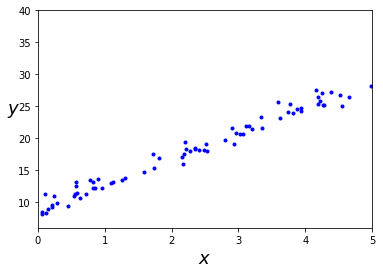

In [18]:
# Generate some data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = 7 * np.random.rand(100,1)
y = 9 + 4 * X+np.random.randn(100,1)

plt.plot(X,y,'b.')
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
_ =plt.axis([0,5,6,40])

Theta0:          9.016,
Theta1:          3.929
Final cost/MSE:  40.881


[0, 5, 6, 40]

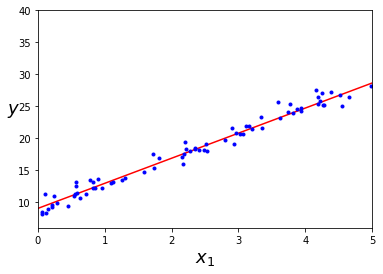

In [24]:
def cal_cost(theta,X,y):
    '''
    
    Calculates the cost for given X and Y. The following shows and example of a single dimensional X
    theta = Vector of thetas 
    X     = Row of X's np.zeros((2,j))
    y     = Actual y's np.zeros((2,1))
    
    where:
        j is the no of features
    '''
    
    m = len(y)
    
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

def stocashtic_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    
    
    for it in range(iterations):
        cost =0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

lr =0.5
n_iter = 50

theta = np.random.randn(2,1)

X_b = np.c_[np.ones((len(X),1)),X]
theta,cost_history = stocashtic_gradient_descent(X_b,y,theta,lr,n_iter)

print('Theta0:          {:0.3f},\nTheta1:          {:0.3f}'.format(theta[0][0],theta[1][0]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

X_new = np.array([[0],[5]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta)
y_predict

plt.plot(X_new,y_predict,'r-')
plt.plot(X,y,'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,5,6,40])

As you can see we've now added in matrix multiplications into our stochastic gradient descent.  I won't go over the code in detail, since it's basically conceptually the same thing as before.  It's worth noting the change in operations.  I leave it as an exercise to the reader to compare the two sets of code.

## Neural Networks

### A naive explanation

Neural networks in a sense really aren't anything new "mathematically".  All we are really doing is applying the chain rule over a vector space ( to do back propagation ).

Let's see a simple example of chain rules:

$$ f(x) = (log(x))^{2} $$

To do the derivative we need to do:

$$ f'(g(x)) = f'(g(x))* g'(x) $$

Therefore:

$$ f'(x) = 2 * log(x) * 1/x $$

So if our functions are over matrices then we are doing neural networks :D

### Psuedo Code

There are two main algorithms in neural networks:

* forward propagation ( predict )
* back propagation ( train )


![](nn_psuedocode.png)

[source](https://en.wikipedia.org/wiki/Artificial_neural_network)


As you can see the basic idea is:

* propagate data through a set of functions which are joined together via matrix multiplication

* At the last layer look at how much your prediction was off by

* update your weight matrix by the gradient * the error (this is a simplification)

* do this until your error is lower than some tolerance


## A Naive Implementation of a Neural Network

Now that we understand the basic notions, let's go ahead and look at a simple example in Python:


In [31]:
"""
This is a vanilla neural network, written from scratch by me.  I adapted this from a series of blog posts on neural networks:

http://iamtrask.github.io/2015/07/12/basic-python-network/

You'll notice that this network is a generalization of the one found in the above blog post

How to use:

Example:

num_hidden_nodes = 5
X = np.array([[1,1],
              [1,0],
              [0,1],
              [0,0]])
                
y = np.array([[0],[1],[1],[1]])
run_once(num_hidden_nodes,X,y)

The above example creates a neural network with 5 hidden nodes, X is the indepent variables, where is y the dependent variables.
Note these are matrices - meaning I'm assuming a multi-dimensional array
If you run this example from the command line:

python back_prop.py 

it will run the the run once method.
"""

import numpy as np
import copy

def check_index(cur_index,size):
    if size - abs(cur_index) > 0:
        return "keep going"
    else:
        return "stop"

def rate_of_change(a,b):
    try:
        return float(b-a)/2
    except:
        return 0 
        
def rates_of_change(listing):
    listing2 = listing[1:]
    return list(map(rate_of_change, listing, listing2))[:-1]

def check_sign(num):
    if num >= 0:
        return "positive"
    else:
        return "negative"
    
def find_inflection_points(listing):
    rates = rates_of_change(listing)
    inflection_points = []
    num_inflection_points = 0
    sign = check_sign(rates[0]) 
    for index,rate in enumerate(rates):
        new_sign = check_sign(rate)
        if new_sign != sign:
            inflection_points.append(rate)
            num_inflection_points += 1
            sign = new_sign
    return inflection_points,num_inflection_points

def get_hidden_layer_index(nn):
    indexes = []
    for index,syn in enumerate(nn):
        if type(syn["name"]) == type(int()):
            indexes.append(index)
    return indexes

def sort_by_key(listing,sort_by):
    """
    Expects a list of dictionaries 
    Returns a list of dictionaries sorted by the associated key
    """
    keys = []
    translate = {}
    for ind,elem in enumerate(listing):
        key = elem[sort_by]
        translate[key] = ind
        keys.append(key)
    keys.sort()
    new_ordering = [translate[key] for key in keys]
    return [listing[i] for i in new_ordering]

def nonlin(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))

def create_connection(num_rows,num_cols):
    return 2*np.random.random((num_rows,num_cols)) -1

def create_nn(input_data,output_data,num_hidden_layers):
    nn = [{"name":"input data","connection":input_data}]
    #input layer
    input_syn = {"name":"input layer"}
    input_syn["connection"] = create_connection(len(input_data[0]),len(input_data))
    nn.append(input_syn)
    #hidden layers
    for i in range(num_hidden_layers):
        syn = {"name":i}
        syn["connection"] = create_connection(len(input_data),len(input_data))
        nn.append(syn)
    #output_layer
    syn = {"name":"output layer"}
    syn["connection"] = create_connection(len(output_data),len(output_data[0]))
    nn.append(syn)
    nn.append({"name":"output data","connection":output_data})
    return nn


def forward_propagate(synapses):
    layers = [synapses[0]["connection"]]
    for ind,synapse in enumerate(synapses[:-1]):
        if ind == 0: continue
        layers.append(
            nonlin(np.dot(layers[ind-1],synapse["connection"]))
        )
    return layers

def back_propagate(layers,synapses):
    errors = [synapses[-1]["connection"] - layers[-1]]
    synapses_index = -1
    layers_index = -1
    errors_index = 0
    deltas_index = 0
    deltas = []
    while len(layers) - abs(layers_index) > 0:
        deltas.append(errors[errors_index]*nonlin(layers[layers_index],deriv=True))
        synapses_index -= 1
        layers_index -= 1
        errors.append(deltas[deltas_index].dot(synapses[synapses_index]["connection"].T))
        errors_index += 1
        deltas_index += 1
    synapses_index = -2
    layers_index = -2
    deltas_index = 0
    while len(layers) - abs(layers_index) >= 0:
        synapses[synapses_index]["connection"] += layers[layers_index].T.dot(deltas[deltas_index])
        synapses_index -= 1
        layers_index -= 1
        deltas_index += 1
    return synapses,errors[0]
            

def run_once(num_hidden_nodes,X,y):
    np.random.seed(1)
    errors = []
    nn = create_nn(X,y,num_hidden_nodes)
    for j in range(70000):
        layers = forward_propagate(nn)
        nn,error = back_propagate(layers,nn)
        if j%10000 == 0:
            errors.append(np.mean(np.abs(error)))
    return errors
        
if __name__ == '__main__':
    #tune(11)
    X = np.array([[1,1],
                  [1,0],
                  [0,1],
                  [0,0]])
                
    y = np.array([[0],
                  [1],
                  [1],
                  [1]])
    for i in range(0,7):
        errors = run_once(i,X,y)
        print("The minimum error for the this network was",min(errors))
        print("The average error for the this network was",sum(errors)/float(len(errors)))
        inflection_points,num_inflection_points = find_inflection_points(errors)
        print("These were the inflection points for ",i)
        print("There were",num_inflection_points,"in total")

The minimum error for the this network was 0.12715212791542269
The average error for the this network was 0.18068367228640816
These were the inflection points for  0
There were 0 in total
The minimum error for the this network was 0.0029750529544725467
The average error for the this network was 0.07204178609933273
These were the inflection points for  1
There were 0 in total
The minimum error for the this network was 0.0017568698739491642
The average error for the this network was 0.05579115465629704
These were the inflection points for  2
There were 0 in total
The minimum error for the this network was 0.0018026102957684298
The average error for the this network was 0.07386961361375748
These were the inflection points for  3
There were 0 in total
The minimum error for the this network was 0.0017049973593299145
The average error for the this network was 0.0816752845275053
These were the inflection points for  4
There were 0 in total
The minimum error for the this network was 0.00147860

## Setting up our network

As you can see from the above our naive neural network has three steps:

* Initialization
* forward propagation (guess)
* back propagation (check)

The initialization step sets up our neural network and the general architecture:

```python
def create_connection(num_rows,num_cols):
    return 2*np.random.random((num_rows,num_cols)) -1

def create_nn(input_data,output_data,num_hidden_layers):
    nn = [{"name":"input data","connection":input_data}]
    #input layer
    input_syn = {"name":"input layer"}
    input_syn["connection"] = create_connection(len(input_data[0]),len(input_data))
    nn.append(input_syn)
    #hidden layers
    for i in range(num_hidden_layers):
        syn = {"name":i}
        syn["connection"] = create_connection(len(input_data),len(input_data))
        nn.append(syn)
    #output_layer
    syn = {"name":"output layer"}
    syn["connection"] = create_connection(len(output_data),len(output_data[0]))
    nn.append(syn)
    nn.append({"name":"output data","connection":output_data})
    return nn
```

Creating a connection really means creating a randomly initialized matrix whose values will update over the course of back propagation.

As you can see, the shapes of our matrices will depend on the previous layer connecting to it - this is because we can only do matrix multiplication with composable shapes.

Our so called "synapse" layers are actually the weight matrices that we will use to join each layer.

## Forward Propagation

Next we have forward propagation, in this stage we apply what's called an activation function to each matrix multiplication.  This activation function is a non-linearity, which takes us from the trivial case of just composing linear regression ontop of itself, to being able to learn many different kinds of patterns.  The activation functions are part of the power of neural networks, they allow us to traverse a vast set of models, which is what makes neural networks so flexible - they aren't just one model, they are in fact an interchangable set of many different models, cobbled together.

Notice also, that the synapses are sort of like the glue connecting one layer to the next for forward propagation.  

```python
def forward_propagate(synapses):
    layers = [synapses[0]["connection"]]
    for ind,synapse in enumerate(synapses[:-1]):
        if ind == 0: continue
        layers.append(
            nonlin(np.dot(layers[ind-1],synapse["connection"]))
        )
    return layers
```

## Back Propagation

Back propagation is the second large innovation in neural networks we will discuss.  The way a neural network is trained, via back propagation means the interplay between the final output and error has a sophisticated and complex relationship with the weight space.  Because the weights at the end of the neural network, influence the nodes at the beginning of the neural network when error is propagated backwards. 

```python
def back_propagate(layers,synapses):
    errors = [synapses[-1]["connection"] - layers[-1]]
    synapses_index = -1
    layers_index = -1
    errors_index = 0
    deltas_index = 0
    deltas = []
    while len(layers) - abs(layers_index) > 0:
        deltas.append(errors[errors_index]*nonlin(layers[layers_index],deriv=True))
        synapses_index -= 1
        layers_index -= 1
        errors.append(deltas[deltas_index].dot(synapses[synapses_index]["connection"].T))
        errors_index += 1
        deltas_index += 1
    synapses_index = -2
    layers_index = -2
    deltas_index = 0
    while len(layers) - abs(layers_index) >= 0:
        synapses[synapses_index]["connection"] += layers[layers_index].T.dot(deltas[deltas_index])
        synapses_index -= 1
        layers_index -= 1
        deltas_index += 1
    return synapses,errors[0]
```

Because I decided to make my forward propagation as obvious as possible, I pushed a lot of complexity to my back propagation algorithm.  Therefor gleaning insight from this implementation would be too challenging.  And therefore should be avoided.

The essence of back propagation is as follows:

* the error gets multiplied by the _derivative_ of the activation function at each layer, these form deltas

Note: activation functions with easy derivatives are generally a good idea

* the deltas get composed via multiplication, updating the weights.

This is sort of like how you can store all the row reduction information for solving a system of linear equations in a single matrix.  We should see these matrices as a set of functions in their own right, except they are highly parameterized.

## Issues in Neural Networks

There are two main types of issues with respect to neural networks:

* vanishing gradients
* exploding gradients

### Vanishing Gradient

The vanishing gradient problem is one of early stopping.  During back propagation the gradients can become increadibly small, due to the following simple fact:

When you multiple two small numbers they get very small very fast:

Example: 

`0.0005 * 0.0007 = 0.00000035`

So essentially what happens is, if the gradients ever head to an increasingly smaller value they will get extremely close to zero very fast.  

Unfortunately, the termination condition for training a neural network is similar to what happens when the gradient gets very small, so it's hard to tell if this is because the neural network has learned something or because the neural network accidentaly learned a weight early on that was small, which propagated to the whole system and led to early stopping

### Exploding Gradient

The exploding gradient has the opposite problem, it's when the gradients become very big very fast, because multiplying two big numbers, also creates a very big number very fast.  If that happens, it's unlikely the neural network will ever converge.

Both are issues, but explodiung gradients, luckily are super obvious because there is only one reason why that would happen.  That's why we only train a neural network for a fixed number of epochs.  This way, if indeed we do have a run away gradient, we'll know it happened and won't waste time training forever.


## Introduction to Keras

Now that we've seen how to work with the machinery of neural networks, let's start making use of our first library.  For this tutorial we will make use of Keras a great high level api for neural networks.

Let's start by looking at a simple regression example:

In [45]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import metrics

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

crashes = sns.load_dataset("car_crashes")
y = crashes["total"]
X = crashes[["speeding", "alcohol", "not_distracted", "no_previous", "ins_premium", "ins_losses"]]

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
estimator.fit(X, y)
y_pred = estimator.predict(X)
print(metrics.mean_squared_error(y, y_pred))

2.08155820757003


Notice, the following:

1. we need to set the number of input dimensions to be the same as the number of columns in our X variable.
2. we specify the loss in the compile phase as mean squared error.  With Neural networks we can even choose the loss metric!

Our model does pretty good!

Let's see a simple example of classification before we move onto interpreting our models:

In [48]:
from sklearn.datasets import load_iris
from sklearn import ensemble
from sklearn import metrics
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics

%matplotlib inline

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

data = load_iris()
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
estimator.fit(data.data, data.target)
y_pred = estimator.predict(data.data)
print(metrics.classification_report(data.target, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Again, unsurprisingly our model does quiet well!  But how do we interpret our results?

References:
* https://datascience.stackexchange.com/questions/10000/what-is-the-difference-between-a-dynamic-bayes-network-and-a-hmm
